# OCR with Pytesseract and OpenCV

In [79]:
import cv2
import pytesseract
import numpy as np
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image
from pytesseract import Output
from matplotlib import pyplot as plt

In [80]:

# Adding custom options
custom_config = r'--psm 6'
#pytesseract.image_to_string(img, config=custom_config)

In [81]:
def showOut(img):
    cv2.imshow('img', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.waitKey(1)

def show(img):
    plt.imshow(img, cmap='gray')
    plt.title('Output')
    plt.show()

# Preprocessing for Tesseract

In [82]:



# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 


In [83]:
img_color = cv2.imread('disjB.png')

#show(img)

img = get_grayscale(img_color)
img = thresholding(img)

#show(img)

#img = deskew(img)
#img = opening(img)
#img = canny(img)




h, w = img.shape
boxes = pytesseract.image_to_boxes(img, config=custom_config) 
img_rec = img.copy()
print(len(boxes))
for b in boxes.splitlines():
    b = b.split(' ')
    crop_img = img[y:y+h, x:x+w]
    show(crop_img)
    

show(img_rec)

# Getting boxes around text

455


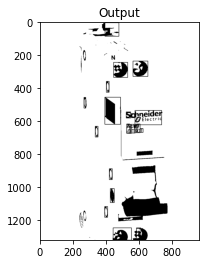

In [84]:

h, w = img.shape
boxes = pytesseract.image_to_boxes(img, config=custom_config) 
img_rec = img.copy()
print(len(boxes))
for b in boxes.splitlines():
    b = b.split(' ')
    img_rec = cv2.rectangle(img_rec, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

show(img_rec)

In [85]:


d = pytesseract.image_to_data(img, config=custom_config, output_type=Output.DICT)
print(d.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


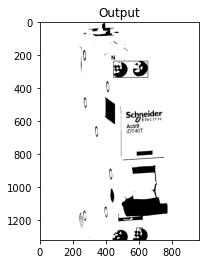

In [86]:

img_rec = img.copy()
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        #crop_img = img[y:y+h, x:x+w]
        #cv2.imshow("cropped", crop_img)
        #cv2.waitKey(0)
        img_rec = cv2.rectangle(img_rec, (x, y), (x + w, y + h), (0, 255, 0), 2)

show(img_rec)

# Text template matching